In [1]:
%config IPCompleter.evaluation='unsafe'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyiron_base import Project
from pyiron_workflow import Workflow, job

/tmp/ipykernel_604/5217064.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
@Workflow.wrap_as.function_node()
def ReadInput(filename, area):
    """
    My custom function to read an input file and process it
    """
    df = pd.read_csv(filename, delimiter=";", header=[0,1], decimal=',')
    df['Stress'] = df['Load']*1000/area
    load = df['Load']*1000
    strain = df['Extensometer elongation'].values.flatten()
    stress = df['Stress'].values.flatten()
    return stress, strain

In [4]:
@Workflow.wrap_as.function_node()
def CalculateYoungsModulus(stress, strain, strain_cutoff=0.2):
    arg = np.argsort(np.abs(np.array(strain)-strain_cutoff))[0]
    fit = np.polyfit(strain[:arg], stress[:arg], 1)
    youngs_modulus = fit[0]*(1/0.01)/1000
    return youngs_modulus

In [5]:
@Workflow.wrap_as.function_node()
def Plot(stress, strain, format='-'):
    plt.plot(strain, stress, format)
    plt.xlabel("Strain [%]");
    plt.ylabel("Stress [MPa]");
    return 1

In [6]:
wf = Workflow("youngs_modulus")
wf.read_input = ReadInput()

wf.youngs_modulus = CalculateYoungsModulus(
    wf.read_input.outputs.stress,
    wf.read_input.outputs.strain,
)

wf.plot = Plot(
    wf.read_input.outputs.stress,
    wf.read_input.outputs.strain
)

{'youngs_modulus__youngs_modulus': 188.4145327564869, 'plot__1': 1}

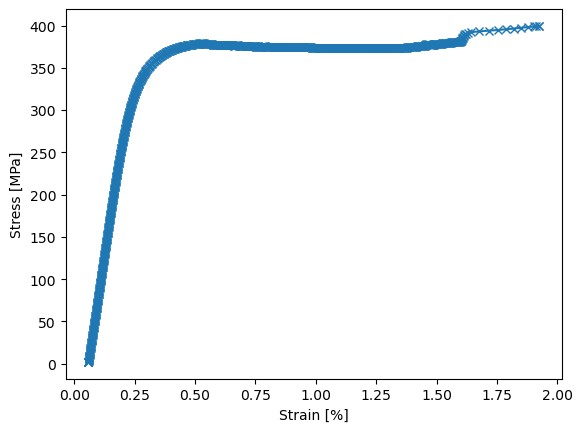

In [7]:
wf(read_input__filename='dataset_1.csv', read_input__area=120.636, plot__format='-x')

In [8]:
wf.draw();
# wf.draw(size=(15,20))

In [9]:
@Workflow.wrap_as.macro_node("youngs_modulus")
def YoungsModulus(wf, filename, area, strain_cutoff):
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    wf.read_input = ReadInput(filename, area)
    wf.youngs_modulus = CalculateYoungsModulus(
        wf.read_input.outputs.stress,
        wf.read_input.outputs.strain,
        strain_cutoff
    )
    return wf.youngs_modulus.outputs.youngs_modulus
    
modulus = YoungsModulus(filename='dataset_1.csv', area=120.636) #, storage_backend="tinybase")

In [10]:
modulus(strain_cutoff=0.2)

{'youngs_modulus': 188.4145327564869}

In [11]:
pr = Project('fgg')
# pr.remove_jobs_silently()

In [12]:
job = pr.create.job.NodeJob("youngs_modulus")
job.input["node"] = modulus

In [13]:
job.run()

The job youngs_modulus was saved and received the ID: 1


In [14]:
job.output.youngs_modulus

188.4145327564869

In [15]:
for x in np.linspace(0.05, 0.6, 12):
    job = pr.create.job.NodeJob(f'job_{x}')
    job.input["node"] = YoungsModulus(
        filename='dataset_1.csv', 
        area=120.636, 
        strain_cutoff=x, 
    )
    job.run()

The job job_0d05 was saved and received the ID: 2


/tmp/ipykernel_604/1252028215.py:4: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(strain[:arg], stress[:arg], 1)


The job job_0d1 was saved and received the ID: 3
The job job_0d15 was saved and received the ID: 4
The job job_0d2 was saved and received the ID: 5
The job job_0d25 was saved and received the ID: 6
The job job_0d3 was saved and received the ID: 7
The job job_0d35 was saved and received the ID: 8
The job job_0d39999999999999997 was saved and received the ID: 9
The job job_0d44999999999999996 was saved and received the ID: 10
The job job_0d49999999999999994 was saved and received the ID: 11
The job job_0d5499999999999999 was saved and received the ID: 12
The job job_0d6 was saved and received the ID: 13


In [16]:
def youngs_modulus(job):
    return job.output.youngs_modulus

def strain_cutoff(job):
    return job.input.node.strain_cutoff.inputs.user_input.value

In [17]:
table = pr.create.table(delete_existing_job=True)
table.convert_to_object = True
table.add['youngs_modulus'] = youngs_modulus
table.add['strain_cutoff'] = strain_cutoff
table.run()

The job table was saved and received the ID: 14


Loading and filtering jobs:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(
/srv/conda/envs/notebook/lib/python3.11/site-packages/pyiron_base/jobs/datamining.py:651: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.pyiron_table._df.to_hdf(


In [18]:
df = table.get_dataframe().sort_values(by='strain_cutoff')
df

job_id  youngs_modulus  strain_cutoff
1        2        1.802219           0.05
2        3      188.978473           0.10
3        4      192.589163           0.15
0        1      188.414533           0.20
4        5      188.414533           0.20
5        6      176.758538           0.25
6        7      162.335225           0.30
7        8      148.207237           0.35
8        9      131.499108           0.40
9       10      113.801282           0.45
10      11       98.760781           0.50
11      12       86.406692           0.55
12      13       76.155046           0.60

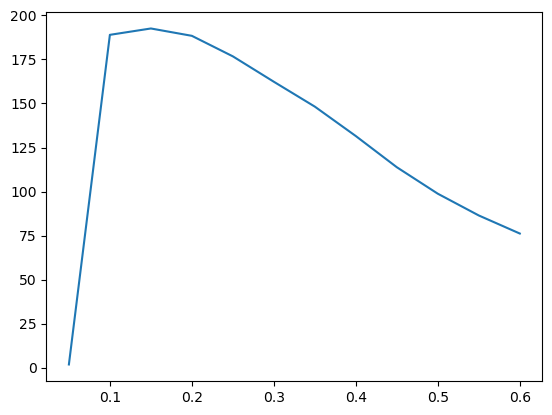

In [19]:
plt.plot(df.strain_cutoff, df.youngs_modulus);